# Classical Time-Series Modelling Methods

Exploring machine learning time-series methods using StatsModels library and US unemployment data generated by BLS.

In [3]:
import pandas as pd

#importing unemployment data
data = pd.read_csv('./BLS Data Series.csv')
data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3
1,2011,9.1,9.0,9.0,9.1,9.0,9.1,9.0,9.0,9.0,8.8,8.6,8.5
2,2012,8.3,8.3,8.2,8.2,8.2,8.2,8.2,8.1,7.8,7.8,7.7,7.9
3,2013,8.0,7.7,7.5,7.6,7.5,7.5,7.3,7.2,7.2,7.2,6.9,6.7
4,2014,6.6,6.7,6.7,6.2,6.3,6.1,6.2,6.1,5.9,5.7,5.8,5.6


In [247]:
unem = pd.melt(data, id_vars='Year', var_name='Month', value_name='Unemployment')
unem['Date'] = unem['Year'].map(str) + " " + unem['Month']
unem['Date'] = pd.to_datetime(unem.Date, yearfirst=True)
# .dt.strftime('%Y-%m')
unem.drop(['Year','Month'], axis=1, inplace=True)
unem.sort_values(by='Date', inplace=True)
unem.index = pd.DatetimeIndex(unem['Date']).to_period(freq='M')
# unem.drop(['Date'], axis=1, inplace=True)
unem.dropna(axis=0, inplace=True)

In [248]:
unem.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 124 entries, 2010-01 to 2020-04
Freq: M
Data columns (total 2 columns):
Unemployment    124 non-null float64
Date            124 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.9 KB


### Autocorrelation

Autocorrelation in statistics is a mathematical tool that is usually used for analyzing functions or series of values, for example, time domain signals. In other words, autocorrelation determines the presence of correlation between the values of variables that are based on associated aspects. In a way, it is the cross-correlation of a signal with itself. Most of the statistical models are based upon the assumption of instance independence, which gets desecrated by autocorrelation.

In [6]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

In [221]:
#Unemployment Difference calculates the difference between the current and 1 preceding value
unem_diff = unem['Unemployment'].diff()
unem_diff.dropna(inplace=True)

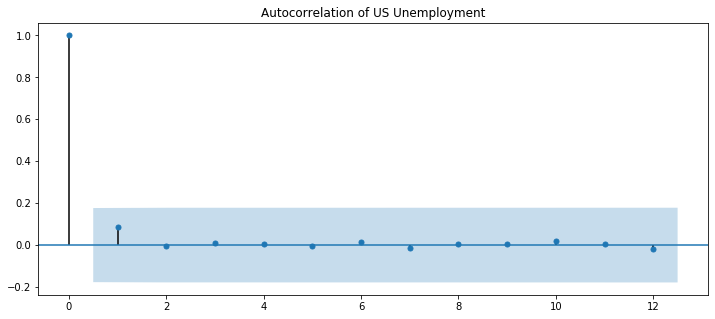

In [222]:
# Using statsmodels acf function we can see there is minimal autocorrelation
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(unem_diff.values, lags=12, ax=ax, title='Autocorrelation of US Unemployment')
plt.show()

### Autoregression 

An Autoregression model predicts the next step in a time-series set of data, based on previous steps. 

In [243]:
from statsmodels.tsa.ar_model import AutoReg
import plotly
import plotly.express as px
import plotly.graph_objects as go
import json

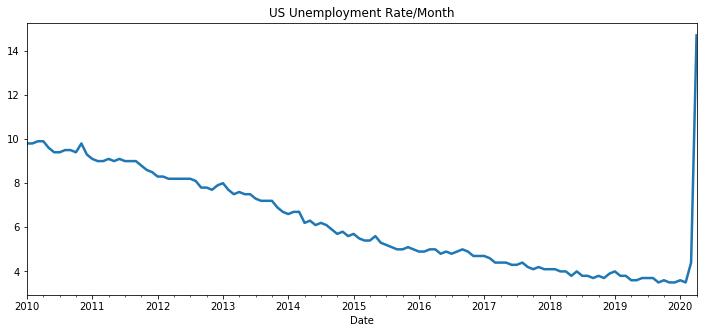

In [251]:
unem['Unemployment'].plot(lw=2.5, figsize=(12,5), title='US Unemployment Rate/Month')

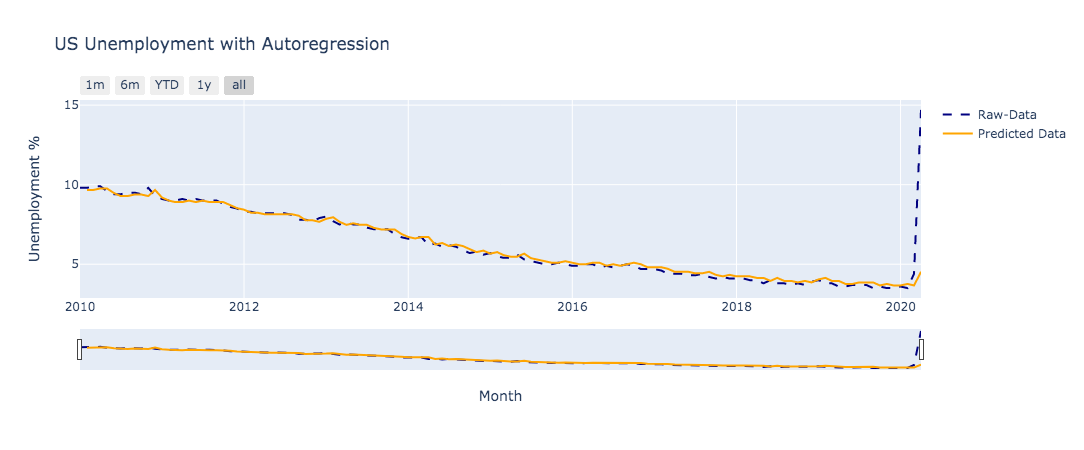

In [270]:
#fitting model
AR = AutoReg(unem['Unemployment'], lags=1)
AR_fit = AR.fit()

#predictions
yhat = AR_fit.predict()

#Plotting AR with original data
AR_join = pd.DataFrame.join(unem, yhat.to_frame(name='y-hat'))

AR_join.to_json()

fig = go.Figure()

fig.add_trace(go.Scatter(x=AR_join.Date, y=AR_join['Unemployment'], name='Raw-Data',
                         line=dict(color='navy', dash='dash')))

fig.add_trace(go.Scatter(x=AR_join.Date, y=AR_join['y-hat'], name='Predicted Data',
                         line=dict(color='orange')))

fig.update_xaxes(rangeslider_visible=True,
                 showspikes=True,
                 spikethickness=1,
                 rangeselector=dict(
                 buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                 ])
                 )
                )

fig.update_yaxes(showspikes=True,
                 spikethickness=1)

fig.update_layout(title='US Unemployment with Autoregression',
                  xaxis_title='Month',
                  yaxis_title='Unemployment %')

fig.show()